`04_kpi.ipynb`

# KPI(Key Performance Index-Indicator) - 핵심 성과 지표

## 메트릭 Metric (측정 가능한 모든 수치)
- 방문자수, 클릭 수, 매출액, 재고량
- 단순한 측정값
## 지표 Indicator (의미가 부여된 메트릭)
- 전월 대비 방문자 증가율, 클릭 전환율, 매출 성장률
- 비교 기준이 있고, 변화-방향성을 보여줌
## KPI (비즈니스 목표와 직결된 핵심 지표)
- CAC(고객 획득 비용), LTV(고객 생애 가치), NPS(순 고객 추천 지수)
- 전략적 의사결정에 직접 영향, 액션 가능한 인사이트 제공

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

warnings.filterwarnings('ignore', category=UserWarning)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 실습용 전자상거래 데이터 생성
np.random.seed(42)

# 고객 데이터 생성
customers = pd.DataFrame({
    'customer_id': range(1, 1001),
    'first_purchase_date': pd.date_range('2022-01-01', periods=1000, freq='D'),
    'acquisition_channel': np.random.choice(['organic', 'paid_search', 'social', 'email'], 1000, 
                                          p=[0.4, 0.3, 0.2, 0.1])
})

# 거래 데이터 생성 (더 현실적인 패턴)
transactions = []
for customer_id in range(1, 1001):
    first_date = customers[customers['customer_id'] == customer_id]['first_purchase_date'].iloc[0]
    
    # 고객별로 다른 구매 패턴 시뮬레이션
    purchase_frequency = np.random.exponential(30)  # 평균 30일마다 구매
    num_purchases = np.random.poisson(3) + 1  # 평균 3회 구매
    
    for i in range(num_purchases):
        purchase_date = first_date + timedelta(days=int(i * purchase_frequency))
        if purchase_date <= datetime(2024, 12, 31):
            transactions.append({
                'customer_id': customer_id,
                'purchase_date': purchase_date,
                'order_value': np.random.lognormal(4, 0.8),  # 로그정규분포로 현실적인 주문금액
                'order_id': len(transactions) + 1
            })

df = pd.DataFrame(transactions)
df['purchase_date'] = pd.to_datetime(df['purchase_date'])

print("데이터셋 개요")
print(f"총 고객 수: {len(customers):,}명")
print(f"총 거래 수: {len(df):,}건")
print(f"기간: {df['purchase_date'].min().date()} ~ {df['purchase_date'].max().date()}")

데이터셋 개요
총 고객 수: 1,000명
총 거래 수: 3,871건
기간: 2022-01-01 ~ 2024-12-28


## RFM 분석
고객을 3가지 측면에서 바라보는 프리즘
- Recency: 얼마나 최근에 구매했는가 (최근성)
- Frequency: 얼마나 자주 구매하는가? (반복성)
- Monetary: 얼마나 많이 구매하는가? (가치)

In [2]:
df.head()

,customer_id,purchase_date,order_value,order_id
0,1,2022-01-01,16.099022,1
1,1,2022-01-07,52.126636,2
2,1,2022-01-13,105.086917,3
3,1,2022-01-19,60.768899,4
4,1,2022-01-25,78.047045,5


In [ ]:
def calculate_rfm(transaction_df: pd.DataFrame, analysis_date='2024-12-31'):
    """
    RFM 분석 함수
    
    Recency: 활성도 측정, 낮을 수록 좋음 (구매일 purchase_date가 낮을 수록 최근에 구매했다는 뜻이므로)
    Frequency: 충성도 측정, 높을 수록 좋음
    Monetary: 가치 측정, 놓을 수록 좋음
    """
    analysis_date = pd.to_datetime(analysis_date)
    rfm = transaction_df.groupby('customer_id').agg({
        # 구매일 purchase_date가 낮을 수록 최근에 구매했다는 뜻이므로 recency는 낮을 수록 좋음
        # Recency
        'purchase_date': lambda x: (analysis_date - x.max()).days,
        # Frequency
        'order_id': 'count',
        # Monetary
        'order_value': 'sum',
    }).reset_index()
    rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']
     # RFM 점수 계산 (5 등급으로 나눔)
    rfm['r_score'] = pd.qcut(rfm_data['recency'], 5, labels=[5, 4, 3, 2, 1])
    rfm['f_score'] = pd.qcut(rfm_data['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
    rfm['m_score'] = pd.qcut(rfm_data['monetary'], 5, labels=[1, 2, 3, 4, 5])
    
    rfm['rfm_score'] = rfm['r_score'].astype(str) + rfm['f_score'].astype(str) + rfm['m_score'].astype(str)
    return rfm


rfm_data = calculate_rfm(df)
rfm_data.head()


# 고객 세그먼트 정의
def segment_customers(rfm_data: pd.DataFrame):
    """
    RFM 점수를 기반으로 고객을 의미있는 세그먼트로 분류
    - R >= 4, F >= 4: 최고
    - R >= 3, F >= 3: 충성
    - R >= 4, F <= 2: 신규
    - R <= 2, F >= 3: 이탈위험
    - R <= 2, F <= 2: 이탈
    - 기타
    """
    def rfm_level(df):
        if (df['r_score'] >= 4) and (df['f_score'] >= 4):
            return '최고'
        elif (df['r_score'] >= 3) and (df['f_score'] >= 3):
            return '충성'
        elif (df['r_score'] >= 4) and (df['f_score'] <= 2):
            return '신규'
        elif (df['r_score'] <= 2) and (df['f_score'] >= 3):
            return '위험'
        elif (df['r_score'] <= 2) and (df['f_score'] <= 2):
            return '이탈'
        else:
            return '기타'
    
    rfm_data['segment'] = rfm_data.apply(rfm_level, axis=1)
    return rfm_data

rfm_segmented = segment_customers(rfm_data)
rfm_segmented

,customer_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,segment
0,1,1053,8,544.086589,1,5,5,155,위험
1,2,983,3,122.971850,1,1,1,111,이탈
2,3,1055,2,325.510131,1,1,4,114,이탈
3,4,1046,5,454.940546,1,4,5,145,위험
4,5,954,8,269.436813,1,5,3,153,위험
...,...,...,...,...,...,...,...,...,...
995,996,19,4,408.573012,5,4,4,544,최고
996,997,86,3,403.810587,5,3,4,534,충성
997,998,95,5,303.249620,5,5,3,553,최고
998,999,3,4,250.638024,5,4,3,543,최고


In [10]:
# segment로 그룹 해서 분석

segment_analysis = rfm_segmented.groupby('segment').agg({
    'customer_id': 'count',
    'recency': 'mean', # 등급별 최종 방문일로부터 지난 평균
    'frequency': 'mean', # 방문 회수 평균
    'monetary': 'mean', # 쓴 돈 평균 
}).round(2)

segment_analysis.columns = ['고객수', '지난날평균', '회수평균', '돈평균']
segment_analysis 

,고객수,지난날평균,회수평균,돈평균
segment,,,,
기타,87,512.67,2.40,163.01
신규,121,251.12,2.45,195.11
위험,208,811.88,5.03,383.14
이탈,192,837.06,2.36,181.27
최고,208,205.57,5.05,379.44
충성,184,391.96,4.44,345.49


In [21]:
# 고객 생애 가치(Customer Lifetime Value)
def calculate_clv(t_df: pd.DataFrame):
    """
    고객 생애 가치(Customer Lifetime Value) 계산
    
    CLV = (평균 주문 가치) * (구매 빈도) * (고객 생존 기간)
    
    해석:
    - CLV > CAC(고객획득비용) : 수익성이 있는 고객
    - CLV/ CAC 비율이 3:1 이상이면 좋은 비즈니스

    """

    # 1. 평균 주문 가치
    avg_order_value = t_df.groupby('customer_id')['order_value'].mean()

    # 2. 구매 빈도(구매 주기)
    def get_annual_purchase(x):
        if len(x) > 1:
            # 1년에 몇 번 정도 사는지 (마지막 구매일 - 최초 구매일 을 날짜)
            return len(x) / ((x['purchase_date'].max() - x['purchase_date'].min()).days + 1) * 365
        else:
            return 1
        
    customer_purchase_frequency = t_df.groupby('customer_id').apply(get_annual_purchase)

    # 3. 고객 생존 기간(1 / 이탈률) -> 실제로는 더 정교한 분석 사용
    lifespan_days = t_df.groupby('customer_id').apply(
        lambda x: (x['purchase_date'].max() - x['purchase_date'].min()).days + 1
    )

    # clv 계산
    clv_data = pd.DataFrame({
        'customer_id': avg_order_value.index,
        'avg_order_value': avg_order_value.values,
        'purchase_frequency': customer_purchase_frequency.values,
        'lifespan_days': lifespan_days.values,
    })

    clv_data['clv'] = (clv_data['avg_order_value'] * clv_data['purchase_frequency'] * clv_data['lifespan_days'] / 365)
    return clv_data

clv_df = calculate_clv(df)

clv_df


C:\Users\amonm\AppData\Local\Temp\ipykernel_17736\4212526361.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  customer_purchase_frequency = t_df.groupby('customer_id').apply(get_annual_purchase)
C:\Users\amonm\AppData\Local\Temp\ipykernel_17736\4212526361.py:28: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  lifespan_days = t_df.groupby('customer_id').apply(


,customer_id,avg_order_value,purchase_frequency,lifespan_days,clv
0,1,68.010824,67.906977,43,544.086589
1,2,40.990617,9.776786,112,122.971850
2,3,162.755066,18.717949,39,325.510131
3,4,90.988109,38.829787,47,454.940546
4,5,33.679602,21.159420,138,269.436813
...,...,...,...,...,...
995,996,102.143253,17.804878,82,408.573012
996,997,134.603529,78.214286,14,403.810587
997,998,60.649924,456.250000,4,303.249620
998,999,62.659506,15.368421,95,250.638024


평균 CLV: $290.89
중앙값 CLV: $264.77
상위 10% 고객: $526.87


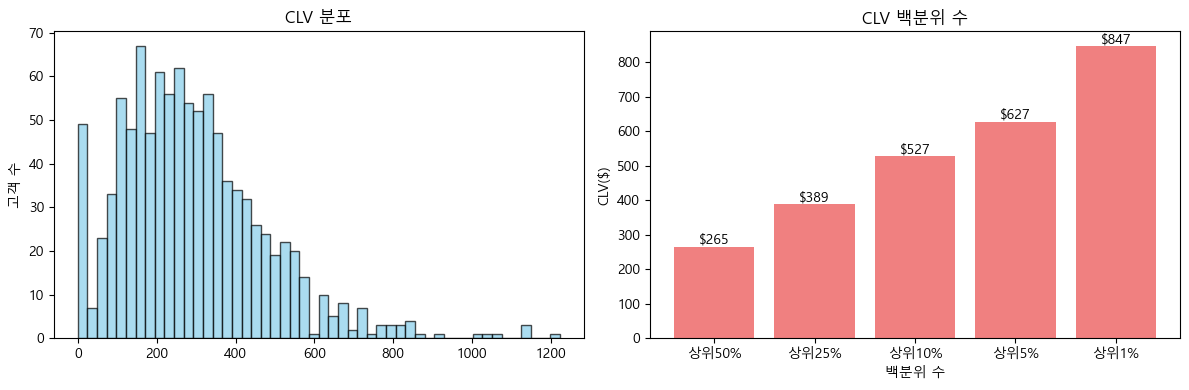

In [30]:
print(f'평균 CLV: ${clv_df['clv'].mean():.2f}')
print(f'중앙값 CLV: ${clv_df['clv'].median():.2f}')
print(f'상위 10% 고객: ${clv_df['clv'].quantile(0.9):.2f}') # 정렬이 되었다는 가정 하에 quantile이 들어감
print('=' * 50)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(clv_df['clv'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('CLV 분포')
plt.ylabel('고객 수')


plt.subplot(1, 2, 2)
clv_percentiles = [50, 75, 90, 95, 99]
clv_values = [clv_df['clv'].quantile(p/100) for p in clv_percentiles]
plt.bar(range(len(clv_percentiles)), clv_values, color='lightcoral')
plt.title('CLV 백분위 수')
plt.xlabel('백분위 수')
plt.xticks(range(len(clv_percentiles)), [f'상위{100 - x}%' for x in clv_percentiles])
plt.ylabel('CLV($)')

# 막대 그래프에 글씨 쓰기
for idx, value in enumerate(clv_values):
    # idx(x좌표)dp, y좌표 막대기 바로 위에, 뭐라고 쓸지, 좌우정렬
    plt.text(idx, value + max(clv_values) * 0.01,f'${value:.0f}', ha='center')


plt.tight_layout()
plt.show()

In [ ]:
# 파레토 법칙 검증

# clv 내림차순으로 정렬
clv_sorted = clv_df.sort_values('clv', ascending=False).reset_index()
# 누적 clv 컬럼 추가
clv_sorted['cum_clv'] = clv_sorted['clv'].cumsum()
# 해당 고객까지의 전체의 몇%인지 컬럼 추가
clv_sorted['cum_clv_pct'] = clv_sorted['cum_clv'] / clv_sorted['clv'].sum() * 100
# 모든 고객 옆에 상위 몇%인지 컬럼 추가
clv_sorted['customer_pct'] = (clv_sorted.index + 1) / len(clv_sorted) * 100

# clv 정렬 기준 상위 20% 에서 누적 clv 열 - 비중 마지막 행

# clv 정렬 기준 상위 20% 고객들만 보는 DF
upper_20p = clv_sorted[clv_sorted['customer_pct'] <= 20] 

# 20% 고객까지의 누적 CLV
top20rev = upper_20p['cum_clv_pct'].iloc[-1]

print(f'파레토 분석 결과: 상위 20% 고객이 {top20rev:.2f}% 매출을 차지')

파레토 분석 결과: 상위 20% 고객이 39.26% 매출을 차지


## 코호트(Cohort) 분석
- 코호트: 공통된 특성 / 경험을 가진 집단
- 특정 시점이나 조건을 기준으로 고객 집단을 추적
- 시간에 따라 행동 패턴의 변화를 분석

📊 코호트 분석 - 고객 유지율
각 셀은 해당 코호트의 고객 유지율을 나타냅니다.
예: 첫 구매 후 3개월째 평균 유지율: 763.6%


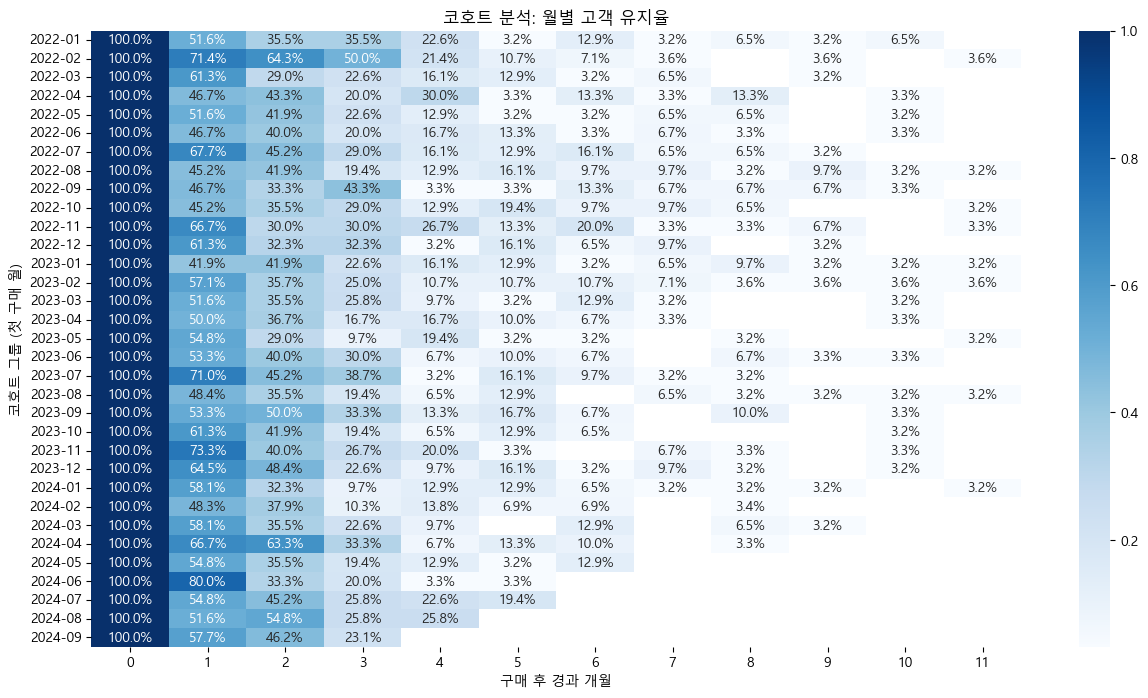


💡 코호트 분석 인사이트
1개월 후 평균 유지율: 56.7%
3개월 후 평균 유지율: 25.3%
6개월 후 평균 유지율: 8.8%


In [48]:
# 첫 구매 월 기준으로 코호트 생성
t_cohort = df.copy()
t_cohort['purchase_period'] = t_cohort['purchase_date'].dt.to_period('M')
# 각 고객의 첫 구매 월
first_purchase = t_cohort.groupby('customer_id')['purchase_date'].min().dt.to_period('M')
first_purchase = first_purchase.reset_index()
first_purchase.columns = ['customer_id', 'cohort_group']

# 코호트 데이터 결합
t_cohort = t_cohort.merge(first_purchase, on='customer_id', how='inner')

# 기간 계산(첫 구매 이후 몇개월 째) -> 이상한 객체가 나왔기 때문에, 처리도 특이한 방법으로 진행
from operator import attrgetter
t_cohort['after_n'] = (t_cohort['purchase_period'] - t_cohort['cohort_group']).apply(attrgetter('n'))


cohort_data = t_cohort.groupby(['cohort_group', 'after_n'])['customer_id'].nunique().reset_index()
cohort_size = first_purchase.groupby('cohort_group')['customer_id'].nunique()

# 각 그룹(최초구매월) 이 N개월이 지났을 때, 총구매회수.
cohort_table = cohort_data.pivot(index='cohort_group', columns='after_n', values='customer_id')

# 각 그룹(최초구매월)별 유지율 계산
cohort_rate = cohort_table.divide(cohort_size, axis=0)



print("📊 코호트 분석 - 고객 유지율")
print("=" * 50)
print("각 셀은 해당 코호트의 고객 유지율을 나타냅니다.")
print(f"예: 첫 구매 후 3개월째 평균 유지율: {cohort_table[3].mean():.1%}")

# 코호트 히트맵 시각화
plt.figure(figsize=(15, 8))
sns.heatmap(cohort_rate.iloc[:, :12], annot=True, fmt='.1%', cmap='Blues')
plt.title('코호트 분석: 월별 고객 유지율')
plt.xlabel('구매 후 경과 개월')
plt.ylabel('코호트 그룹 (첫 구매 월)')
plt.show()

# 코호트별 인사이트
print("\n💡 코호트 분석 인사이트")
print("=" * 50)
retention_1m = cohort_rate[1].mean()
retention_3m = cohort_rate[3].mean() 
retention_6m = cohort_rate[6].mean() if 6 in cohort_rate.columns else 0

print(f"1개월 후 평균 유지율: {retention_1m:.1%}")
print(f"3개월 후 평균 유지율: {retention_3m:.1%}")
if retention_6m > 0:
    print(f"6개월 후 평균 유지율: {retention_6m:.1%}")

# 유지율 개선 방안 제시
if retention_1m < 0.3:
    print("\n⚠️ 1개월 유지율이 낮습니다. 온보딩 프로세스 개선 필요")
if retention_3m < 0.15:
    print("⚠️ 3개월 유지율이 낮습니다. 고객 참여 프로그램 강화 필요")

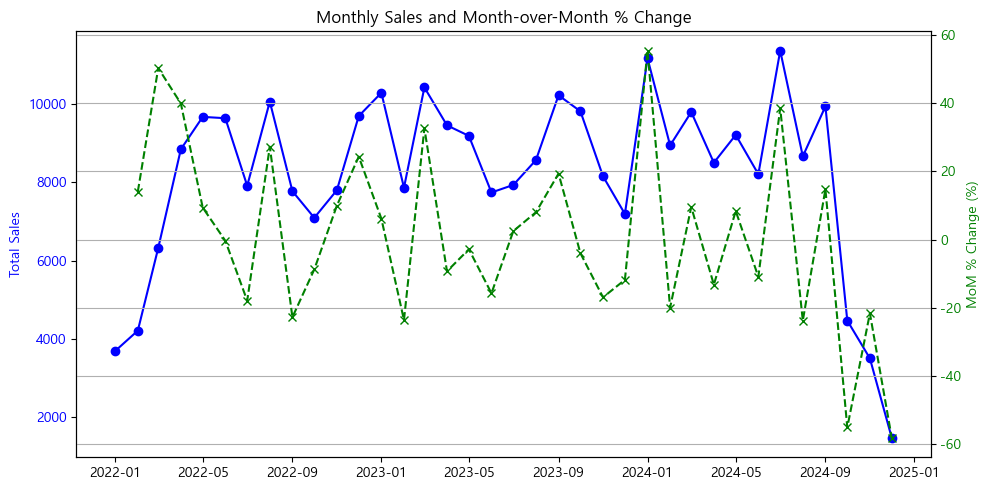

In [59]:
# Month Over Month (전월 대비)
# Year Over Year (전년 대비)

"""
월별/연별 성장률 계산 및 트렌드 분석

성장률의 비즈니스적 의미:
- MoM(Month over Month): 단기 성장 모멘텀 파악
- YoY(Year over Year): 계절성을 배제한 장기 성장 트렌드
"""

# MoM 성장률('order_value')
# YoY 성장률
# 시각화까지

monthly_sales = df.groupby(df['purchase_date'].dt.to_period('M'))['order_value'].sum()

# Percent change (MoM growth rate)
monthly_sales_pct = monthly_sales.pct_change()

# Absolute change
monthly_sales_diff = monthly_sales.diff()


monthly_summary = pd.DataFrame({
    'Total': monthly_sales,
    'MoM Change': monthly_sales.diff(),
    'MoM %': monthly_sales.pct_change()
})

monthly_summary

monthly_summary.index = monthly_summary.index.to_timestamp()


fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Total Sales
ax1.plot(monthly_summary.index, monthly_summary['Total'], color='blue', marker='o', label='Total Sales')
ax1.set_ylabel('Total Sales', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis for MoM %
ax2 = ax1.twinx()
ax2.plot(monthly_summary.index, monthly_summary['MoM %'] * 100, color='green', marker='x', linestyle='--', label='MoM % Change')
ax2.set_ylabel('MoM % Change (%)', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Title and layout
plt.title('Monthly Sales and Month-over-Month % Change')
fig.tight_layout()
plt.grid(True)
plt.show()



In [68]:

monthly_revenue = df.groupby( # 각 월별 주문 총합 
    df['purchase_date'].dt.to_period('M')
)['order_value'].sum().reset_index()

monthly_revenue.columns = ['month', 'revenue']

# month가 peirod 타입이기 때문에 DF로 바꿈
monthly_revenue['month'] = monthly_revenue['month'].dt.to_timestamp()


# MoM 계산
monthly_revenue['revenue_lag1'] = monthly_revenue['revenue'].shift(1)
monthly_revenue['mom_growth'] = ( monthly_revenue['revenue'] - monthly_revenue['revenue_lag1']) / monthly_revenue['revenue_lag1']

# YoY 성장률 (전년 동월) ('년'만 기준으로는 년수가 적기 때문에 이런 방식으로 활용)
monthly_revenue['revenue_lag12'] = monthly_revenue['revenue'].shift(12)
monthly_revenue['yoy_growth'] = ( monthly_revenue['revenue'] - monthly_revenue['revenue_lag12']) / monthly_revenue['revenue_lag12']

growth_data = monthly_revenue



최근 12개월 평균 MoM 성장률 -0.1%
최근 12개월 평균 YoY 성장률 -0.1%


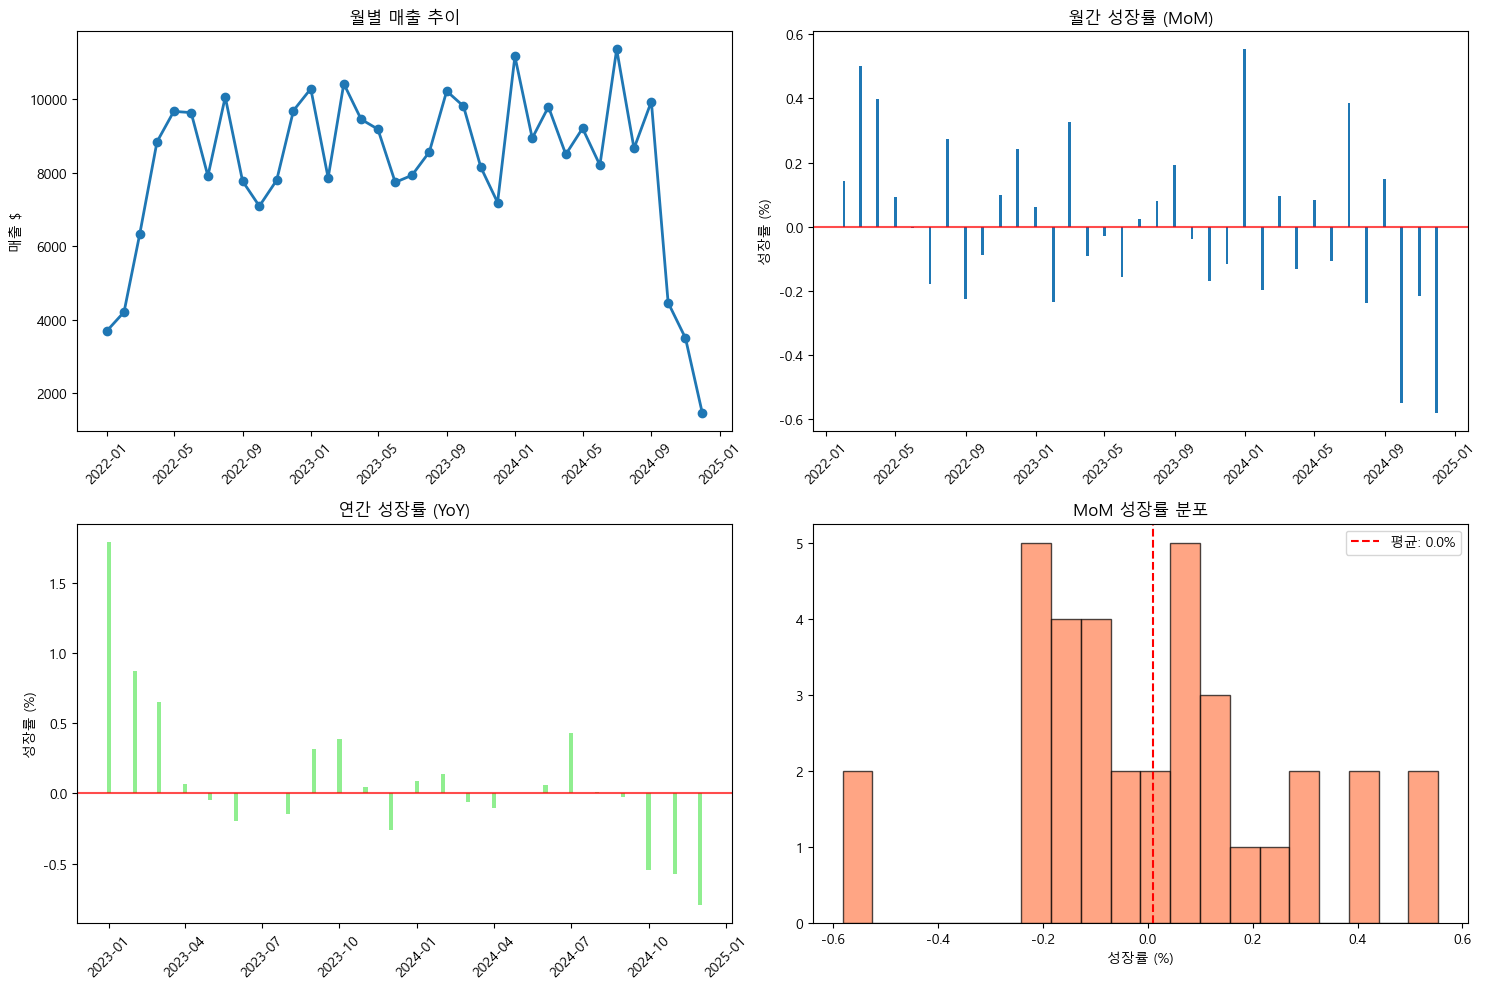

In [96]:
# 최근 12개월 성장률 요약

# 전월 대비 성장률 평균
avg_mom = growth_data.tail(12)['mom_growth'].mean()
# 전년 동월 대비 성장률 평균
avg_yoy = growth_data.tail(12)['yoy_growth'].mean()

print(f'최근 12개월 평균 MoM 성장률 {avg_mom:.1f}%')
print(f'최근 12개월 평균 YoY 성장률 {avg_yoy:.1f}%')

# 기존 subplot (x, y, n) 말고 다른 방법
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
a1 = axes[0, 0]
a2 = axes[0, 1]
a3 = axes[1, 0]
a4 = axes[1, 1]

# 데이터가 주어 -> 그래프가 주어(x축, y축)
a1.plot(growth_data['month'], growth_data['revenue'], marker='o', linewidth=2)
a1.set_title('월별 매출 추이')
a1.set_ylabel('매출 $')
a1.tick_params(axis='x', rotation=45)

a2.bar(growth_data['month'], growth_data['mom_growth'], width=5)
a2.axhline(y=0, color='red', linestyle='-', alpha=0.7)
a2.set_title('월간 성장률 (MoM)')
a2.set_ylabel('성장률 (%)')
a2.tick_params(axis='x', rotation=45)

# YoY 성장률
a3.bar(growth_data['month'], growth_data['yoy_growth'], color='lightgreen', width=5)
a3.axhline(y=0, color='red', linestyle='-', alpha=0.7)
a3.set_title('연간 성장률 (YoY)')
a3.set_ylabel('성장률 (%)')
a3.tick_params(axis='x', rotation=45)

# 성장률 분포
growth_rates = growth_data['mom_growth'].dropna()
a4.hist(growth_rates, bins=20, alpha=0.7, color='coral', edgecolor='black')
a4.axvline(x=growth_rates.mean(), color='red', linestyle='--', 
                  label=f'평균: {growth_rates.mean():.1f}%')
a4.set_title('MoM 성장률 분포')
a4.set_xlabel('성장률 (%)')
a4.legend()

plt.tight_layout()
plt.show()

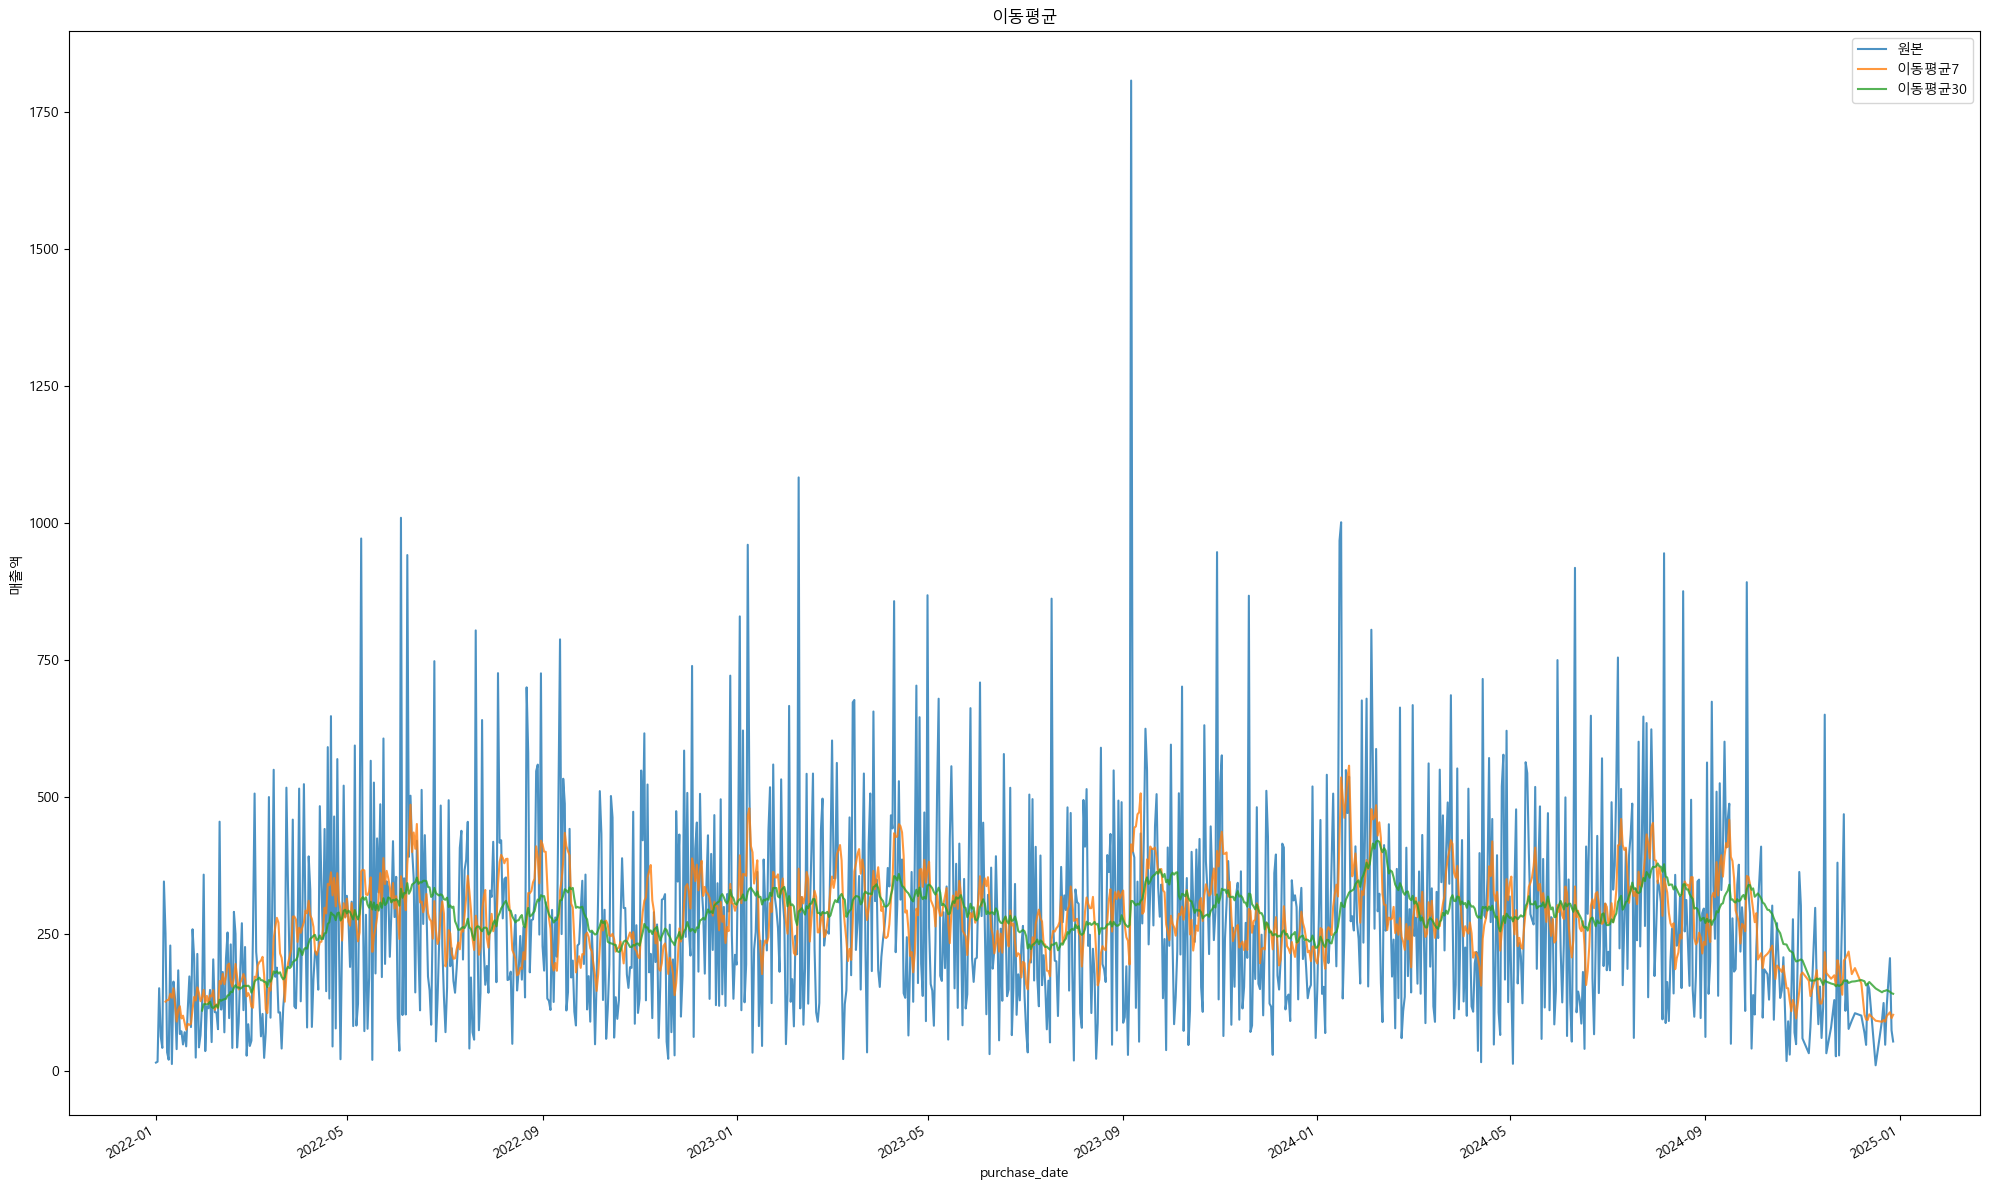

In [95]:
# 트렌드 분석



# 일별 매출 집계

daily_revenue = df.groupby('purchase_date')['order_value'].sum().reset_index()

# 다양한 기간의 'revenue' 이동평균 (주간, 월간, 분기)

daily_revenue['ma_7'] = daily_revenue['order_value'].rolling(window=7).mean()
daily_revenue['ma_30'] = daily_revenue['order_value'].rolling(window=30).mean()



# 트렌드 방향성 분석 + 시각화



daily_revenue.set_index('purchase_date')[['order_value', 'ma_7', 'ma_30']].plot(
    figsize=(20, 12), alpha=0.8
)
plt.title('이동평균')
plt.ylabel('매출액')
plt.legend(['원본', '이동평균7', '이동평균30'])
plt.tight_layout()
plt.show()


📈 트렌드 분석 결과
최근 7일 트렌드: 상승 (1.5)
최근 30일 트렌드: 하락 (-0.9)


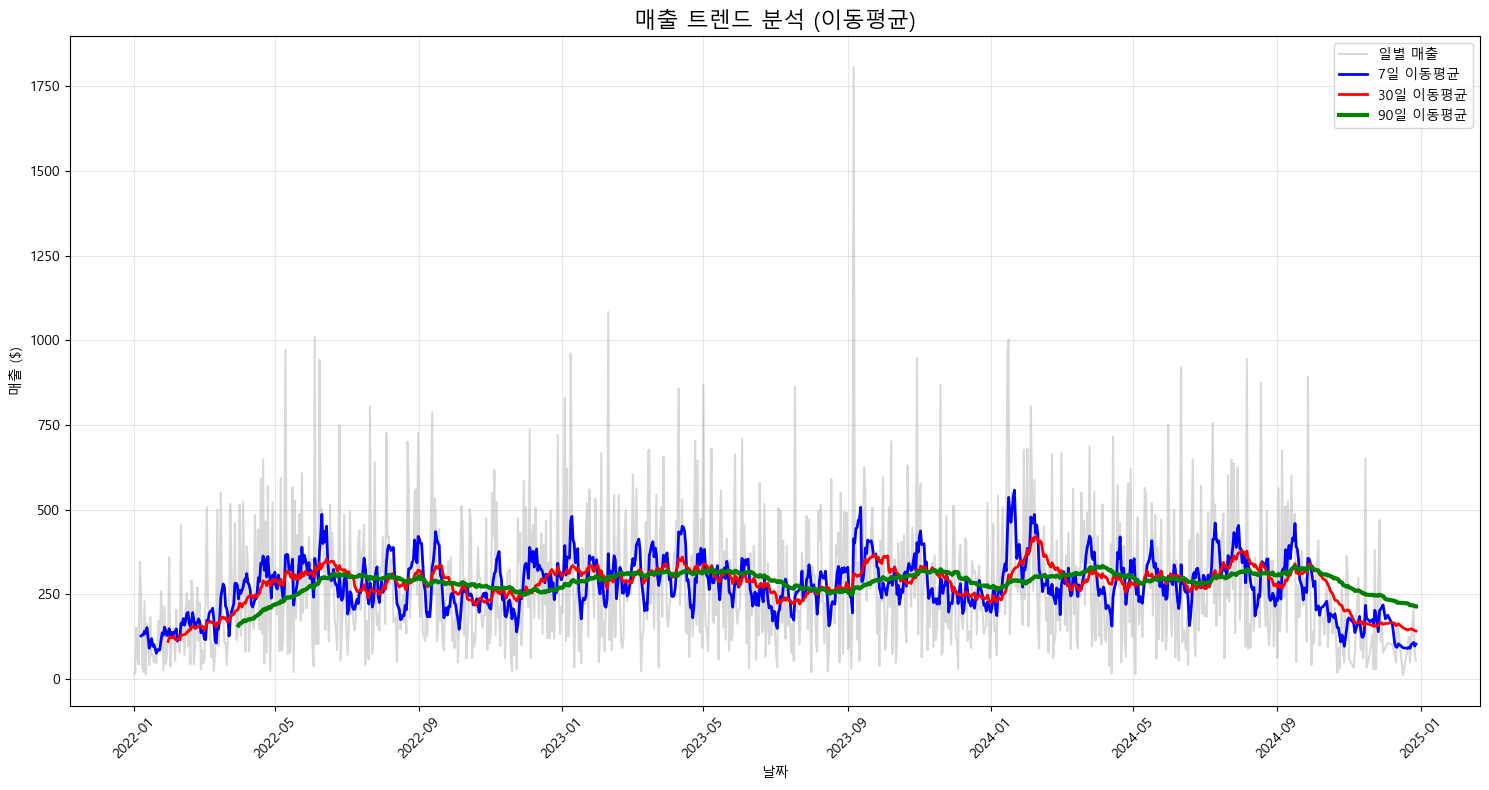

In [97]:
def rolling_trend_analysis(transactions_df):
    """
    이동 평균을 활용한 트렌드 분석
    
    이동 평균의 활용:
    - 단기 변동성 제거하여 장기 트렌드 파악
    - 계절성 패턴 식별
    - 이상치의 영향 최소화
    """
    
    # 일별 매출 집계
    daily_revenue = transactions_df.groupby(
        transactions_df['purchase_date'].dt.date
    )['order_value'].sum().reset_index()
    
    daily_revenue.columns = ['date', 'revenue']
    daily_revenue['date'] = pd.to_datetime(daily_revenue['date'])
    daily_revenue = daily_revenue.sort_values('date')
    
    # 다양한 기간의 이동 평균 계산
    daily_revenue['ma_7'] = daily_revenue['revenue'].rolling(window=7).mean()    # 주간
    daily_revenue['ma_30'] = daily_revenue['revenue'].rolling(window=30).mean()  # 월간
    daily_revenue['ma_90'] = daily_revenue['revenue'].rolling(window=90).mean()  # 분기
    
    # 트렌드 방향성 분석
    daily_revenue['trend_7'] = daily_revenue['ma_7'].diff()
    daily_revenue['trend_30'] = daily_revenue['ma_30'].diff()
    
    return daily_revenue

trend_data = rolling_trend_analysis(df)

print("📈 트렌드 분석 결과")
print("=" * 50)

# 최근 트렌드 방향성
recent_trend_7 = trend_data['trend_7'].tail(7).mean()
recent_trend_30 = trend_data['trend_30'].tail(30).mean()

print(f"최근 7일 트렌드: {'상승' if recent_trend_7 > 0 else '하락'} ({recent_trend_7:.1f})")
print(f"최근 30일 트렌드: {'상승' if recent_trend_30 > 0 else '하락'} ({recent_trend_30:.1f})")

# 트렌드 시각화
plt.figure(figsize=(15, 8))

plt.plot(trend_data['date'], trend_data['revenue'], alpha=0.3, color='gray', label='일별 매출')
plt.plot(trend_data['date'], trend_data['ma_7'], color='blue', label='7일 이동평균', linewidth=2)
plt.plot(trend_data['date'], trend_data['ma_30'], color='red', label='30일 이동평균', linewidth=2)
plt.plot(trend_data['date'], trend_data['ma_90'], color='green', label='90일 이동평균', linewidth=3)

plt.title('매출 트렌드 분석 (이동평균)', fontsize=16)
plt.xlabel('날짜')
plt.ylabel('매출 ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# 마케팅 지출 및 채널 확장성 점수 (1~100)
marketing_data = pd.DataFrame({
    'channel': ['Google Ads', 'Facebook', 'Instagram', 'Email', 'Organic', 'Referral'],
    'marketing_spend': [50000, 40000, 25000, 10000, 0, 3000],
    'scalability_score': [90, 85, 75, 60, 95, 70]
})

# 고객 획득 수 / LTV / 획득 시간
acquisition_data = pd.DataFrame({
    'channel': ['Google Ads', 'Facebook', 'Instagram', 'Email', 'Organic', 'Referral'],
    'customers_acquired': [200, 180, 120, 80, 300, 60],
    'avg_ltv': [1200, 1000, 800, 700, 950, 1000],
    'avg_acquisition_days': [5, 7, 10, 20, 40, 25] # 해당 채널에서 구매 전환까지 걸린 시간(날)
})

acquisition_data

,channel,customers_acquired,avg_ltv,avg_acquisition_days
0,Google Ads,200,1200,5
1,Facebook,180,1000,7
2,Instagram,120,800,10
3,Email,80,700,20
4,Organic,300,950,40
5,Referral,60,1000,25


In [ ]:
# CAC (Customer Acquisition Cost - 고객 획득 비용) 
# 고객 품질(특정 채널을 통해 유입된 고객이 얼마나 돈을 사용하는지) 등 측정 가능

perf_df = pd.merge(marketing_data, acquisition_data, on='channel')

# 1. 'avg_ltv' 고객 퀄리티 가중치
perf_df['quality_weight'] = perf_df['avg_ltv'] / perf_df['avg_ltv'].mean()

# 2. 'avg_acq_days' 시간 가치 가중치
perf_df['time_weight'] = perf_df['avg_acquisition_days'].max() / perf_df['avg_acquisition_days']

# 3. 'scalability' 확장정 가중치
perf_df['scalability_weight'] = perf_df['scalability_score'] / 100

# 종합 가중치( qw - 50%, tw - 30%, sw - 20%)

perf_df['composite_weight'] = (
    perf_df['quality_weight'] * 0.5 +
    perf_df['time_weight'] * 0.3 + 
    perf_df['scalability_weight'] * 0.2
)

# 일반 CAC 계산 ->  각 채널별 1인 데려오는 비용
perf_df['simple_cac'] = perf_df['marketing_spend'] / perf_df['customers_acquired']

# 가중치 반영한 CAC 계산
perf_df['weighted_cac'] = perf_df['simple_cac'] / perf_df['composite_weight']

perf_df[['channel', 'simple_cac', 'weighted_cac']]



,channel,marketing_spend,scalability_score,customers_acquired,avg_ltv,avg_acquisition_days,quality_weight,time_weight,scalability_weight,composite_weight,simple_cac,weighted_cac
0,Google Ads,50000,90,200,1200,5,1.274336,8.000000,0.90,3.217168,250.000000,77.708093
1,Facebook,40000,85,180,1000,7,1.061947,5.714286,0.85,2.415259,222.222222,92.007610
2,Instagram,25000,75,120,800,10,0.849558,4.000000,0.75,1.774779,208.333333,117.385523
3,Email,10000,60,80,700,20,0.743363,2.000000,0.60,1.091681,125.000000,114.502270
4,Organic,0,95,300,950,40,1.008850,1.000000,0.95,0.994425,0.000000,0.000000
5,Referral,3000,70,60,1000,25,1.061947,1.600000,0.70,1.150973,50.000000,43.441489


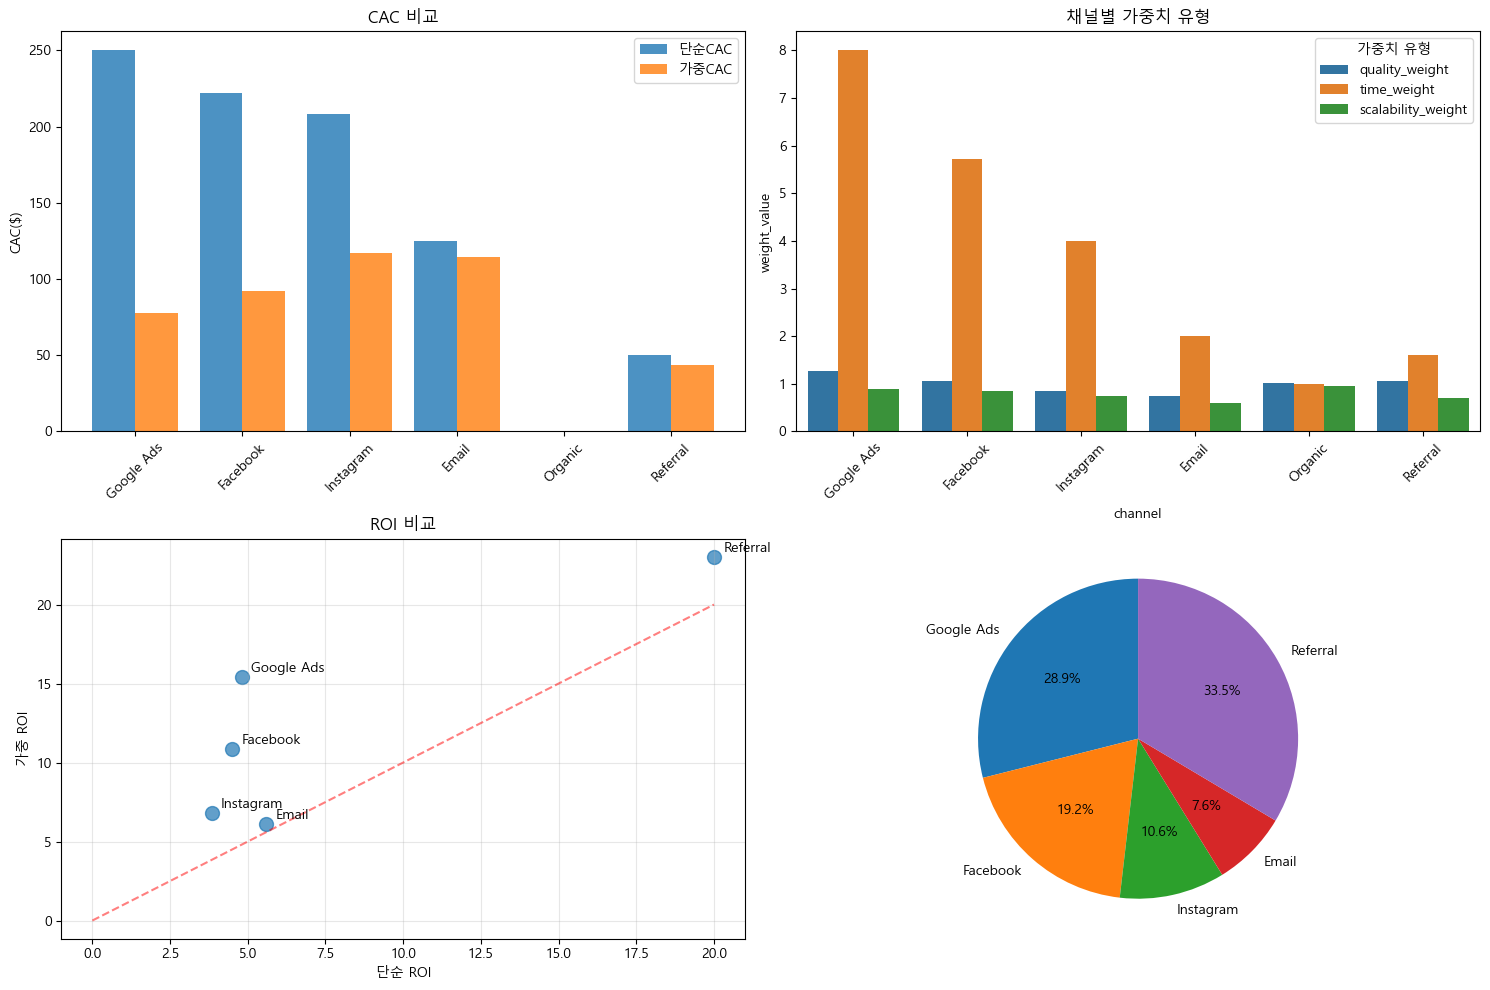

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(15, 10))
x_pos = np.arange(len(perf_df))
a1, a2, a3, a4 = axis[0, 0], axis[0, 1], axis[1, 0], axis[1, 1]

# 단순 CAC, 가중 CAC 비교

a1.bar(x_pos-0.2, perf_df['simple_cac'], 0.4, label='단순CAC', alpha=0.8)
a1.bar(x_pos+0.2, perf_df['weighted_cac'], 0.4, label='가중CAC', alpha=0.8)
a1.set_title('CAC 비교')
a1.set_xticks(x_pos)
a1.set_xticklabels(perf_df['channel'], rotation=45)
a1.set_ylabel('CAC($)')
a1.legend()

# 가중치 구성 요소 분석
weight_component = perf_df[['channel', 'quality_weight', 'time_weight', 'scalability_weight']]
# pivot 의 반대 melt
weight_melted = weight_component.melt(id_vars=['channel'], var_name='weight_type', value_name='weight_value')

import seaborn as sns
sns.barplot(data=weight_melted, x='channel', y='weight_value', hue='weight_type', ax=a2)
a2.tick_params(axis='x', rotation=45)
a2.set_title('채널별 가중치 유형')
a2.legend(title='가중치 유형')

# ROI(return on investment) 분석(LTV / CAC 비율)
perf_df['simple_roi'] = perf_df['avg_ltv'] / perf_df['simple_cac']
perf_df['weighted_roi'] = perf_df['avg_ltv'] / perf_df['weighted_cac']

# 산점도
a3.scatter(perf_df['simple_roi'], perf_df['weighted_roi'], s=100, alpha=0.7)
# 각 점마다 채널명 표시하기
for idx, channel in enumerate(perf_df['channel']):
    a3.annotate(channel, (perf_df['simple_roi'].iloc[idx]+0.3, perf_df['weighted_roi'].iloc[idx]+0.3))

# 대각선 그리기: 선 위는 단순 ROI보다 가중 ROI가 더 큰 경우 = 과소평가 되고 있는 채널들
a3.plot([0, 20], [0, 20] , 'r--', alpha=0.5) 

a3.set_title('ROI 비교')
a3.set_xlabel('단순 ROI')
a3.set_ylabel('가중 ROI')
a3.grid(True, alpha=0.3)


# 최적 마케팅 믹스 제안 (파이 그래프)
"""
ROI와 Scalability를 함께 고려할 예정
1. 효율성 지표(Efficiency Score) 라는 항목으로 ROI, 확장성을 동시에 계산 -> 성과도 좋고 확장 여지도 큼
2. 예산 배분 기준 -> 효율성 지표에 따라

"""
budget_opt = perf_df.copy()
# Organic행 삭제
budget_opt.drop(4, axis=0, inplace=True)
# 숫자가 너무 커서 나눔
budget_opt['eff_score'] = budget_opt['weighted_roi'] * budget_opt['scalability_score'] / 100
budget_opt['recommend_pct'] = budget_opt['eff_score'] / budget_opt['eff_score'].sum() * 100

a4.pie(budget_opt['recommend_pct'], labels=budget_opt['channel'], autopct='%1.1f%%', startangle=90)


plt.tight_layout()
plt.show()

,channel,marketing_spend,scalability_score,customers_acquired,avg_ltv,avg_acquisition_days,quality_weight,time_weight,scalability_weight,composite_weight,simple_cac,weighted_cac
0,Google Ads,50000,90,200,1200,5,1.274336,8.000000,0.90,3.217168,250.000000,77.708093
1,Facebook,40000,85,180,1000,7,1.061947,5.714286,0.85,2.415259,222.222222,92.007610
2,Instagram,25000,75,120,800,10,0.849558,4.000000,0.75,1.774779,208.333333,117.385523
3,Email,10000,60,80,700,20,0.743363,2.000000,0.60,1.091681,125.000000,114.502270
4,Organic,0,95,300,950,40,1.008850,1.000000,0.95,0.994425,0.000000,0.000000
5,Referral,3000,70,60,1000,25,1.061947,1.600000,0.70,1.150973,50.000000,43.441489
